# Report without groud Truth v1.0

## Input prameters

In [7]:
#%cd /data/mutect2/data_simulation/100x/170469

/data/mutect2/data_simulation/100x/170469


In [80]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 26
TITLE_SIZE = 36
FIGSIZE = (16, 8)
GRID = True
COLORS = [
    "blue",
    "red",
    "green",
    "magenta",
    "black",
    "brown",
    "orange",
    "salmon",
    "teal",
    "coral",
    "lime",
    "purple",
    "cyan",
    "lavender",
    "turquoise",
    "darkgreen",
    "tan",
    "lightblue",
    "pink",
    "yellow",
    "gold",
]

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=TITLE_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("axes", grid=GRID)  # is grid on
plt.rc("axes", prop_cycle=plt.cycler(color=COLORS))
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=TITLE_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=FIGSIZE)  # size of the figure

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from os.path import join as pjoin
from matplotlib.lines import Line2D
home=os.environ['HOME']
sys.path.append(pjoin(home, 'proj1/VariantCalling/src/'))
from python.utils import revcomp

af_hist = pd.read_hdf('collect_stats.h5','af_hist')
ins_del_hete = pd.read_hdf('collect_stats.h5','ins_del_hete')
ins_del_homo = pd.read_hdf('collect_stats.h5','ins_del_homo')
motifs = pd.read_hdf('collect_stats.h5','snp_motifs')
#eval
CompOverlap = pd.read_hdf('collect_stats.h5','eval_CompOverlap')
CountVariants = pd.read_hdf('collect_stats.h5','eval_CountVariants')
TiTvVariantEvaluator = pd.read_hdf('collect_stats.h5','eval_TiTvVariantEvaluator')
IndelLengthHistogram = pd.read_hdf('collect_stats.h5','eval_IndelLengthHistogram')
IndelSummary = pd.read_hdf('collect_stats.h5','eval_IndelSummary')
MetricsCollection = pd.read_hdf('collect_stats.h5','eval_MetricsCollection')
ValidationReport = pd.read_hdf('collect_stats.h5','eval_ValidationReport')
VariantSummary = pd.read_hdf('collect_stats.h5','eval_VariantSummary')


In [ ]:
outplot_motif0 = pjoin(workdir, "motif0_bars.png")
outplot_motif1 = pjoin(workdir, "motif1_plot.png")
outplot_motif1_heatmap = pjoin(workdir, "motif1_heatmap.png")

## Allele Frequency histogram

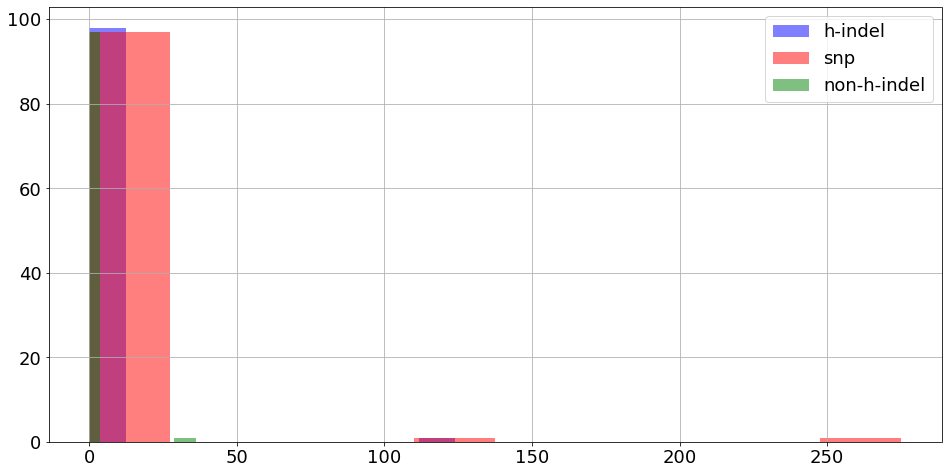

In [89]:


nbins = 100
bin_edges = pd.Series(np.linspace(0, 1, nbins))

for group in af_hist.columns:

    plt.hist(af_hist[group], alpha=0.5, label=group) ##???
    plt.legend(loc='upper right')
    
plt.show()


## Insertion Deletion Statistics

In [83]:
ins_del_hete.columns = pd.Series(ins_del_hete.columns).apply(lambda x: f"h-mer {x}")
ins_del_homo.columns = pd.Series(ins_del_homo.columns).apply(lambda x: f"h-mer {x}")

## Heterozygous

In [84]:
ins_del_hete

,h-mer 1,h-mer 2,h-mer 3,h-mer 4,h-mer 5,h-mer 6,h-mer 7,h-mer 8,h-mer 9,h-mer 10,h-mer 11,h-mer 12
ins A,0,2,1,0,1,0,1,0,0,0,2,0
ins G,28,40,18,6,0,1,0,0,0,0,0,0
del A,0,0,0,1,1,2,0,0,0,0,0,1
del G,0,1,2,5,6,3,1,0,0,0,1,0


## Homozygous

In [85]:
ins_del_homo

,h-mer 1,h-mer 2,h-mer 3,h-mer 4,h-mer 5,h-mer 6,h-mer 7,h-mer 8,h-mer 9,h-mer 10,h-mer 11,h-mer 12
ins A,0,0,0,0,0,0,0,0,0,0,0,0
ins G,1,2,0,0,0,1,0,1,0,0,0,0
del A,0,1,0,0,0,0,0,0,0,0,1,0
del G,0,0,1,0,0,1,0,0,0,1,0,1


# Snp statistics

In [92]:
motifs_0 = motifs.reset_index()
motifs_0 = (
    motifs_0.assign(ref=motifs_0["ref_motif"].str.slice(1, 2))
    .groupby(["ref", "alt_1"])
    .agg({"size": "sum"})
)["size"]
#motifs_0

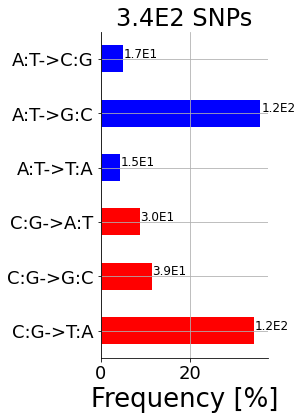

In [103]:

base_colors = {"A": "b", "C": "r", "T": "y", "G": "g"}
dpi = 150

def plot_motifs0_bars(ax=None):
    if ax is None:
        plt.figure(figsize=(3, 6))
        ax = plt.gca()
    plt.sca(ax)

    x = (motifs_0).sort_index(ascending=False)
    bbox_extra_artists = [
        plt.title(f"{x.sum():.1E} SNPs".replace("E+0", "E"), fontsize=24)
    ]
    (x / motifs_0.sum() * 100).plot.barh(
        color=[base_colors.get(v) for v in x.index.get_level_values("ref")],
        ax=ax,
    )
    plt.yticks(
        ticks=range(6),
        labels=[
            f"{ref}:{revcomp(ref)}->{alt}:{revcomp(alt)}" for ref, alt in x.index.values
        ],
    )
    for j, (_, row) in enumerate(x.to_frame().iterrows()):
        bbox_extra_artists += [
            plt.text(
                row["size"] / motifs_0.sum() * 101,
                j + 0.03,
                f"{row['size']:.1E}".replace("E+0", "E"),
            )
        ]
    plt.ylabel("")
    plt.xlabel("Frequency [%]")
    # plt.xlim(0, ax.get_xlim()[1]+0.1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    return bbox_extra_artists


bbox_extra_artists = plot_motifs0_bars()

# plt.savefig(
#     outplot_motif0, dpi=dpi, bbox_inches="tight", bbox_extra_artists=bbox_extra_artists
# )

## Trinucleotide

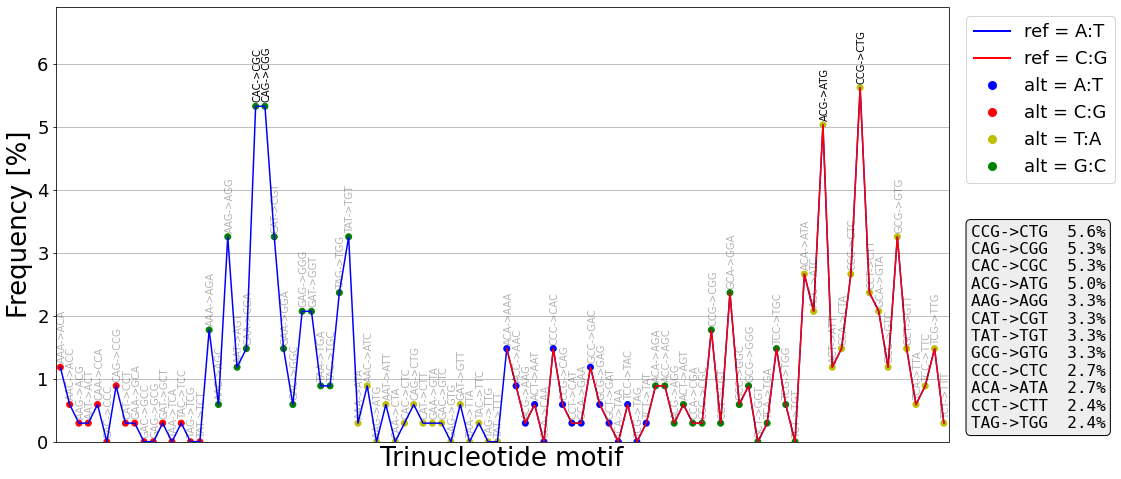

In [97]:
bbox_extra_artists = list()
x = (motifs / motifs.sum()).reset_index()
x = x.assign(
    ref=x["ref_motif"].str.slice(1, 2),
    alt_motif=x["ref_motif"].str.slice(0, 1) + x["alt_1"] + x["ref_motif"].str.slice(2),
)
x = x.sort_values(["ref", "alt_1"]).reset_index()
x["size"] *= 100
x["size"].plot(color="b")  # .query("ref == 'A'")
x.query("ref == 'C'")["size"].plot(color="r")
plt.scatter(
    x.index,
    x["size"],
    color=[base_colors.get(v) for v in x["alt_1"]],
    alpha=1,
)
plt.xlim(-0.5, 95.5)
plt.ylim(0, plt.gca().get_ylim()[1] + 1)
plt.xticks([])
bbox_extra_artists.append(plt.xlabel("Trinucleotide motif"))
bbox_extra_artists.append(plt.ylabel("Frequency [%]"))

th = x["size"].mean() + 2 * x["size"].std()
for ind, row in x.iterrows():
    plt.text(
        ind - 0.35,
        row["size"] + 0.1,
        f"{row['ref_motif']}->{row['alt_motif']}",
        rotation=90,
        fontsize=10,
        alpha=1 if row["size"] > th else 0.3,
    )

ax = plt.gca()
plt.rcParams["font.family"] = "monospace"
table_str = "\n".join(
    (
        x["ref_motif"]
        + "->"
        + x["alt_motif"]
        + "  "
        + (x["size"] / 100).apply(lambda x: f"{x:.1%}")
    )
    .loc[x.sort_values("size", ascending=False).head(12).index]
    .values
)
bbox_extra_artists.append(
    ax.text(
        1.025,
        0.5,
        table_str,
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="#EEEEEE"),
    )
)
plt.rcParams["font.family"] = "sans-serif"

legend_elements = [
    Line2D([0], [0], color="b", lw=2, label="ref = A:T"),
    Line2D([0], [0], color="r", lw=2, label="ref = C:G"),
] + [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=f"alt = {k}:{revcomp(k)}",
        markerfacecolor=v,
        markersize=10,
    )
    for k, v in base_colors.items()
]
bbox_extra_artists.append(plt.legend(handles=legend_elements, bbox_to_anchor=[1.01, 1]))



# Heatmap

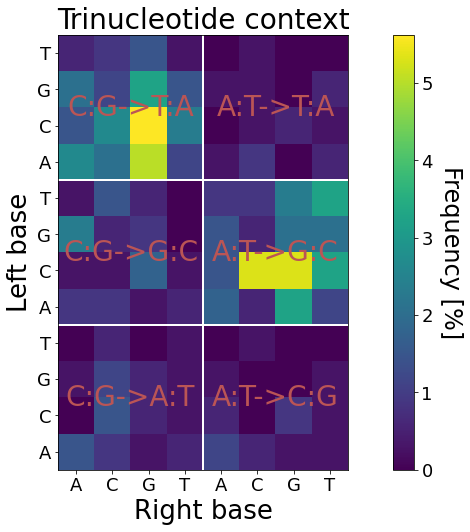

In [102]:
def plot_heatmap(motifs,ax=None):
    if ax is None:
        plt.figure()
        ax = plt.gca()
    plt.sca(ax)

    plt.title("Trinucleotide context", fontsize=28)
    x = (motifs / motifs.sum()).reset_index()
    x = x.assign(
        ref=x["ref_motif"].str.slice(1, 2),
        alt_motif=x["ref_motif"].str.slice(0, 1)
        + x["alt_1"]
        + x["ref_motif"].str.slice(2),
        left=x["ref_motif"].str.slice(0, 1),
        right=x["ref_motif"].str.slice(2),
    )
    x = x.assign(
        family=x.apply(
            lambda y: f"{y['ref']}:{revcomp(y['ref'])}->{y['alt_1']}:{revcomp(y['alt_1'])}",
            axis=1,
        )
    )
    x = x.pivot_table(
        index=[
            "family",
            "left",
        ],
        columns=["right"],
        values="size",
    ).sort_index(ascending=False)

    bbox_extra_artists = list()
    data = np.concatenate((x.iloc[:12, :], x.iloc[12:, :]), axis=1) * 100
    plt.imshow(data, cmap="viridis")
    cbar = plt.colorbar()
    cbar.ax.get_yaxis().set_ticks(
        range(
            int(np.ceil(min(cbar.ax.get_yaxis().get_ticklocs()))),
            1 + int(max(cbar.ax.get_yaxis().get_ticklocs())),
        )
    )
    cbar.ax.set_ylabel("Frequency [%]", fontsize=24, rotation=270, labelpad=30)
    plt.xticks(range(8), list(x.columns) + list(x.columns))
    plt.yticks(range(12), x.iloc[:12, :].index.get_level_values("left"))
    plt.ylabel("Left base")
    plt.xlabel("Right base")
    plt.grid()
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    plt.plot(np.ones(2) * (xlim[0] + (xlim[1] - xlim[0]) / 2), ylim, "-w", linewidth=2)
    plt.plot(xlim, np.ones(2) * (ylim[0] + (ylim[1] - ylim[0]) / 3), "-w", linewidth=2)
    plt.plot(
        xlim, np.ones(2) * (ylim[0] + (ylim[1] - ylim[0]) * 2 / 3), "-w", linewidth=2
    )

    X = np.repeat(
        [
            [
                (xlim[0] + (xlim[1] - xlim[0]) / 4),
                (xlim[0] + (xlim[1] - xlim[0]) * 3 / 4),
            ]
        ],
        3,
        axis=0,
    )
    Y = np.repeat(
        [
            [
                (ylim[0] + (ylim[1] - ylim[0]) * 5 / 6),
                (ylim[0] + (ylim[1] - ylim[0]) * 3 / 6),
                (ylim[0] + (ylim[1] - ylim[0]) / 6),
            ]
        ],
        2,
        axis=0,
    ).T
    T = np.vstack(
        (
            x.iloc[:12:4, :].index.get_level_values("family").values,
            x.iloc[12::4, :].index.get_level_values("family").values,
        )
    ).T

    for xx, yy, tt in zip(X.flatten(), Y.flatten(), T.flatten()):
        plt.text(xx, yy, tt, color="#BB5555", fontsize=28, ha="center", va="center")

plot_heatmap(motifs)


# Statistics tables from VariantEval

In [21]:
CompOverlap

,CompOverlap,CompFeatureInput,EvalFeatureInput,JexlExpression,Novelty,nEvalVariants,novelSites,nVariantsAtComp,compRate,nConcordant,concordantRate
0,CompOverlap,dbsnp,eval,none,all,392,31,361,92.09,358,99.17
1,CompOverlap,dbsnp,eval,none,known,361,0,361,100.00,358,99.17
2,CompOverlap,dbsnp,eval,none,novel,31,31,0,0.00,0,0.00


In [22]:
CountVariants

,CountVariants,CompFeatureInput,EvalFeatureInput,JexlExpression,Novelty,nProcessedLoci,nCalledLoci,nRefLoci,nVariantLoci,variantRate,...,nHomRef,nHomVar,nSingletons,nHomDerived,heterozygosity,heterozygosityPerBp,hetHomRatio,indelRate,indelRatePerBp,insertionDeletionRatio
0,CountVariants,dbsnp,eval,none,all,3217346917,392,0,392,0.00000012,...,0,292,80,0,3.11e-08,32173469.00,0.34,1.62e-08,61872056.00,0.65
1,CountVariants,dbsnp,eval,none,known,3217346917,361,0,361,0.00000011,...,0,281,66,0,2.49e-08,40216836.00,0.28,1.31e-08,76603498.00,0.78
2,CountVariants,dbsnp,eval,none,novel,3217346917,31,0,31,0.00000001,...,0,11,14,0,6.22e-09,160867345.00,1.82,3.11e-09,321734691.00,0.25


In [23]:
TiTvVariantEvaluator

,TiTvVariantEvaluator,CompFeatureInput,EvalFeatureInput,JexlExpression,Novelty,nTi,nTv,tiTvRatio,nTiInComp,nTvInComp,TiTvRatioStandard,nTiDerived,nTvDerived,tiTvDerivedRatio
0,TiTvVariantEvaluator,dbsnp,eval,none,all,236,101,2.34,35402107,17690562,2.00,0,0,0.00
1,TiTvVariantEvaluator,dbsnp,eval,none,known,222,96,2.31,221,97,2.28,0,0,0.00
2,TiTvVariantEvaluator,dbsnp,eval,none,novel,14,5,2.80,35401886,17690465,2.00,0,0,0.00


In [24]:
IndelLengthHistogram

,IndelLengthHistogram,CompFeatureInput,EvalFeatureInput,JexlExpression,Novelty,Length,Freq
0,IndelLengthHistogram,dbsnp,eval,none,all,-10,0.04
1,IndelLengthHistogram,dbsnp,eval,none,all,-9,0.00
2,IndelLengthHistogram,dbsnp,eval,none,all,-8,0.00
3,IndelLengthHistogram,dbsnp,eval,none,all,-7,0.04
4,IndelLengthHistogram,dbsnp,eval,none,all,-6,0.02
5,IndelLengthHistogram,dbsnp,eval,none,all,-5,0.00
6,IndelLengthHistogram,dbsnp,eval,none,all,-4,0.09
7,IndelLengthHistogram,dbsnp,eval,none,all,-3,0.09
8,IndelLengthHistogram,dbsnp,eval,none,all,-2,0.13
9,IndelLengthHistogram,dbsnp,eval,none,all,-1,0.21


In [25]:
IndelSummary

,IndelSummary,CompFeatureInput,EvalFeatureInput,JexlExpression,Novelty,n_SNPs,n_singleton_SNPs,n_indels,n_singleton_indels,n_indels_matching_gold_standard,...,n_large_deletions,n_large_insertions,insertion_to_deletion_ratio_for_large_indels,n_coding_indels_frameshifting,n_coding_indels_in_frame,frameshift_rate_for_coding_indels,SNP_het_to_hom_ratio,indel_het_to_hom_ratio,ratio_of_1_and_2_to_3_bp_insertions,ratio_of_1_and_2_to_3_bp_deletions
0,IndelSummary,dbsnp,eval,none,all,339,80,53,19,0,...,2,2,1.00,0,0,NA,0.31,0.53,NA,4.00
1,IndelSummary,dbsnp,eval,none,known,320,66,43,15,0,...,2,2,1.00,0,0,NA,0.26,0.50,NA,6.00
2,IndelSummary,dbsnp,eval,none,novel,19,14,10,4,0,...,0,0,NA,0,0,NA,2.80,0.67,NA,2.00


In [26]:
MetricsCollection

,MetricsCollection,CompFeatureInput,EvalFeatureInput,JexlExpression,Novelty,concordantRate,nSNPs,nSNPloci,nIndels,nIndelLoci,indelRatio,indelRatioLociBased,tiTvRatio
0,MetricsCollection,dbsnp,eval,none,all,99.17,339,338,53,52,0.66,0.65,2.34
1,MetricsCollection,dbsnp,eval,none,known,99.17,320,319,43,42,0.79,0.78,2.31
2,MetricsCollection,dbsnp,eval,none,novel,0.00,19,19,10,10,0.25,0.25,2.80


In [27]:
ValidationReport

,ValidationReport,CompFeatureInput,EvalFeatureInput,JexlExpression,Novelty,nComp,TP,FP,FN,TN,...,CompMonoEvalNoCall,CompMonoEvalFiltered,CompMonoEvalMono,CompMonoEvalPoly,CompPolyEvalNoCall,CompPolyEvalFiltered,CompPolyEvalMono,CompPolyEvalPoly,CompFiltered,nDifferentAlleleSites
0,ValidationReport,dbsnp,eval,none,all,60691373,361,0,60691012,0,...,0,0,0,0,60691012,0,0,361,0,0
1,ValidationReport,dbsnp,eval,none,known,378,361,0,17,0,...,0,0,0,0,17,0,0,361,0,0
2,ValidationReport,dbsnp,eval,none,novel,60690995,0,0,60690995,0,...,0,0,0,0,60690995,0,0,0,0,0


In [28]:
VariantSummary

,VariantSummary,CompFeatureInput,EvalFeatureInput,JexlExpression,Novelty,nSamples,nProcessedLoci,nSNPs,TiTvRatio,SNPNoveltyRate,nSNPsPerSample,TiTvRatioPerSample,SNPDPPerSample,nIndels,IndelNoveltyRate,nIndelsPerSample,IndelDPPerSample,nSVs,SVNoveltyRate,nSVsPerSample
0,VariantSummary,dbsnp,eval,none,all,1,3217346917,338,2.34,5.62,338,2.34,338.0,52,19.23,52,52.0,0,NA,0
1,VariantSummary,dbsnp,eval,none,known,1,3217346917,319,2.31,0.00,319,2.31,319.0,42,0.00,42,42.0,0,NA,0
2,VariantSummary,dbsnp,eval,none,novel,1,3217346917,19,2.80,100.00,19,2.80,19.0,10,100.00,10,10.0,0,NA,0
